### Package install

In [30]:
pip install sklearn

     |████████████████████████████████| 7.2 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 1.6 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=68d41c2f11aa01c5a4e6c9a0cf39688ccacabf983798565c6a93e9f249177a81
  Stored in directory: /Users/youngihnkwon/Library/Caches/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


### Import libraries 

In [55]:
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

### Define image properties

In [7]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

### Prepare dataset for training 

In [17]:
filenames = os.listdir("../Deeplearning/train/")

In [18]:
categories=[]
for filename in filenames:
    category=filename.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [19]:
df

,filename,category
0,dog.8011.jpg,1
1,cat.5077.jpg,0
2,dog.7322.jpg,1
3,cat.2718.jpg,0
4,cat.10151.jpg,0
...,...,...
24995,dog.8008.jpg,1
24996,dog.1992.jpg,1
24997,dog.12412.jpg,1
24998,cat.2701.jpg,0


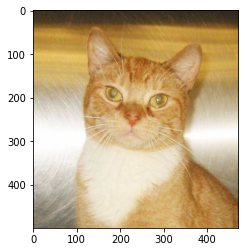

In [4]:
sample = random.choice(filenames)
image = load_img("../Deeplearning/train/"+sample)
plt.imshow(image)

### Build Model

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

### Callback 함수 

In [20]:
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
#earlystop = EarlyStopping(patience = 10)
#learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
#callbacks = [earlystop,learning_rate_reduction]

### Manage data

In [50]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,random_state=42)
train_df = train_df.reset_index(drop=True) # 명령으로 인덱스를 보통의 자료열로 바꿀 수도 있다. 이 때 인덱스 열은 자료열의 가장 선두로 삽입된다.
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=30

In [79]:
total_train

20000

### Training data generator

* shear_range : Float type, shear intensity(shear angle in counter-clockwise direction as radians)
* shear means that the image will be distorted along an axis
* zooom_range : Float type, Range for random zoom
* horizontal_flip : Boolean type, Randomly flip inputs horizontally
* rescale : rescaling factor, Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided. 

* flow_from_dataframe : dataframe과 디렉토리의 위치를 전달받아 증강/정규화된 데이터의 배치를 생성합니다. 

In [49]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "../Deeplearning/train/",x_col='filename',y_col='category',
                                                 target_size=IMAGE_SIZE,
                                                 class_mode='categorical',
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.


### Validation data generator 

In [51]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../Deeplearning/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


### Model Training 

In [52]:
epochs=5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/5
666/666 [==============================] - 376s 564ms/step - loss: 0.4573 - accuracy: 0.7839 - val_loss: 0.5800 - val_accuracy: 0.7225
Epoch 2/5
666/666 [==============================] - 386s 579ms/step - loss: 0.4046 - accuracy: 0.8172 - val_loss: 0.4339 - val_accuracy: 0.8056
Epoch 3/5
666/666 [==============================] - 394s 592ms/step - loss: 0.3602 - accuracy: 0.8408 - val_loss: 0.4330 - val_accuracy: 0.8147
Epoch 4/5
666/666 [==============================] - 395s 593ms/step - loss: 0.3311 - accuracy: 0.8563 - val_loss: 0.8304 - val_accuracy: 0.7052
Epoch 5/5
666/666 [==============================] - 360s 540ms/step - loss: 0.2828 - accuracy: 0.8797 - val_loss: 2.0550 - val_accuracy: 0.6384


### Virtualize Training

In [63]:
history.history

{'loss': [0.4572688043117523,
  0.4045552611351013,
  0.36018848419189453,
  0.33113718032836914,
  0.28281158208847046],
 'accuracy': [0.7839258909225464,
  0.8172258138656616,
  0.840761125087738,
  0.8562844395637512,
  0.8797195553779602],
 'val_loss': [0.5799745321273804,
  0.43385037779808044,
  0.43302300572395325,
  0.8304382562637329,
  2.055044651031494],
 'val_accuracy': [0.7224899530410767,
  0.8056225180625916,
  0.8146586418151855,
  0.7052208781242371,
  0.6383534073829651]}

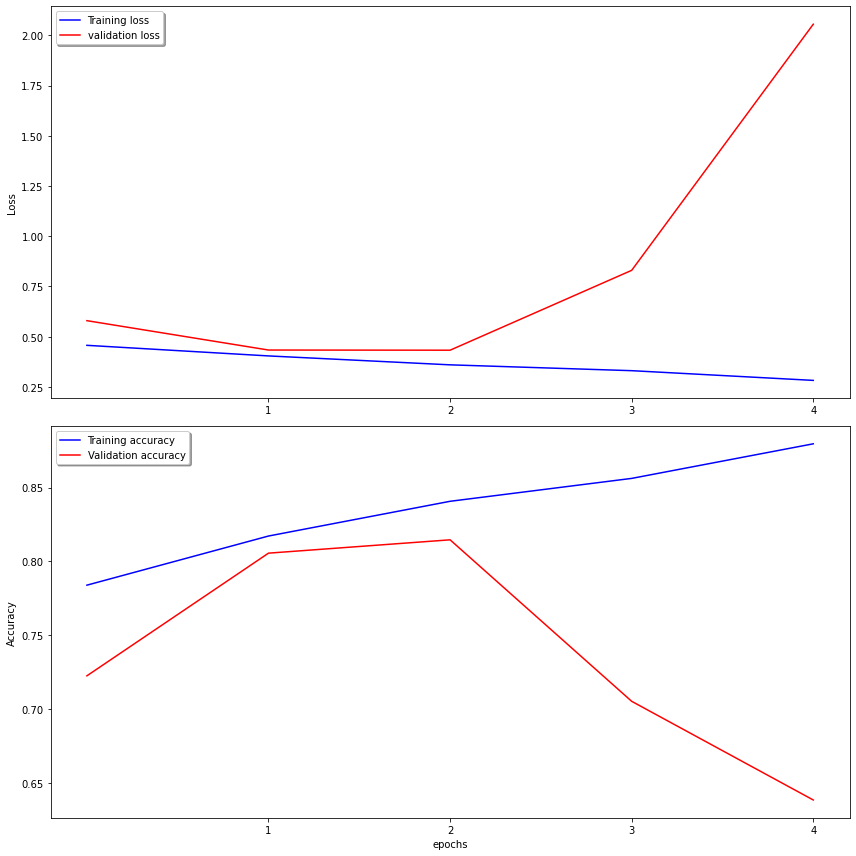

In [78]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
# ax1.set_yticks(np.arange(0, 1, 0.05))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('Loss')

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best', shadow=True)

plt.xlabel('epochs')
plt.tight_layout()
plt.show()